## Data Preparation and Exploration

In this notebook we will download the data for the example project, visualize it to understand the tasks we will solve and then convert it to suitable data formats for the different tasks.
We are using data from the paper [Microscopy-based assay for semi-quantitative detection of SARS-CoV-2 specific antibodies in human sera](https://onlinelibrary.wiley.com/doi/full/10.1002/bies.202000257) for segmentation and classification tasks in microscopy imaging.

This data was used in a serological assay for SARS-CoV-2 and we will use it for nucleus and cell segmentation as well as classifying cells into infect / non-infected.

In [ ]:
import os

import h5py
import napari

In [ ]:
# this is the folder where all data will be stored. you can change it to store the data somehwere else.
data_folder = "data"
os.makedirs(data_folder, exist_ok=True)

### 1. Download

Download the data from zenodo and unzip it. If you have already downloaded the data you may skip these steps.

In [ ]:
# the data is on zenodo
data_url = "https://zenodo.org/record/5092850/files/covid-if-groundtruth.zip?download=1"

In [ ]:
# download the data using the requests library
import requests
from tqdm import tqdm
from shutil import copyfileobj

# this function is for downloading the data.
# you don't need to understand what's going on here.
def download_url(url, path):
    with requests.get(url, stream=True) as r:
        if r.status_code != 200:
            r.raise_for_status()
            raise RuntimeError(f"Request to {url} returned status code {r.status_code}")
        file_size = int(r.headers.get("Content-Length", 0)) 
        desc = f"Download {url} to {path}"
        if file_size == 0:
            desc += " (unknown file size)"
        with tqdm.wrapattr(r.raw, "read", total=file_size, desc=desc) as r_raw, open(path, "wb") as f:
            copyfileobj(r_raw, f)


# run the download function to donwnload the data to the file 'data.zip' in the data folder 
download_url(data_url, os.path.join(data_folder, "data.zip"))

In [ ]:
# unzip the data using the zipfile library
import zipfile

# function for unzipping the archive we have just downloaded and then removing the zip
def unzip(zip_path, dst, remove=True):
    with zipfile.ZipFile(zip_path, "r") as f:
        f.extractall(dst)
    if remove:
        os.remove(zip_path)
        
unzip(os.path.join(data_folder, "data.zip"), data_folder)

### 2. Data Inspection

Inspect the data and understand the data format. The data we have just downloaded uses the HDF5 data format. If you don't know hdf5 yet: this data format is more complex than image data formats like tif you're probably familar with, and it allows to store multiple datasets (e.g. images) in one file. This makes it very convenient for storing data for training deep learning models, because the training images and labels can be kept in the same file.

In [ ]:
# first lets check what we have actually downloaded.
# we can use os.listdir to check the contents of a folder
file_names = os.listdir(data_folder)
file_names.sort()
print(len(file_names), "have been downloaded")
print("The first five files are:", file_names[:5])

In [ ]:
# You should see that 49 files have been downloaded and that they have the file extension .h5.
# This extension stands for HDF5 files. HDF5 is a hierarchical data format that can store multiple datasets in a single file.
# Now we inspect the content of one of these files using the h5py library:
file_path = os.path.join(data_folder, file_names[0])

# We use a visitor pattern to check out the contents of the file.
# the 'inspector' function will be called for each element in the file hierarchy. 

def inspector(name, node):
    # hdf5 files contain 'Dataset' that hold the actual data. With the function below we print
    # the name and shape if the inspector function encounters a dataset
    if isinstance(node, h5py.Dataset):  
        print("The h5 file contains a dataset @", name, "with shape", node.shape)

with h5py.File(file_path, "r") as f:
    f.visititems(inspector)

You should see several datasets that are part of the hdf5 file. The datasets that start with `raw/` are the images:
- `raw/serum_IgG/s0` contains the antibody staining that stains the cytosol with an intensity that scales with the antbody binding.
- `raw/nuclei/s0` contains the nucleus staining.
- `raw/marker/s0` contains a viral marker that can be used to check whether a cell is infected or not.

The datasets that start with `labels/` contain the ground-truth data:
- `labels/infected/cells/s0` contains the cell instance segmentation.
- `labels/infected/nuclei/s0` contains a semantic nucleus segmentation, where the value indicates whether a cell is infected (value: 1) or not (value: 2).

In addition, the h5 file contains some datasets that start with `tables/` that contain tables with additional information about the cell segmentation. We can ignore these.

**If this file format confuses you don't worry! All you need to know is that you can load one of the images in the file using the h5py library (see next section), and the explanation here about what the different images in the dataset represent.**

### 3. Data Visualization

Now we load the image data into memory (as numpy arrays) and then display them with [napari](https://napari.org/stable/). Napari is an image viewer. If you're not familiar with it: it's similar to Fiji, but written fully in python which makes it much easier to integrate with deep learning applications.

In [ ]:
# first we load all the relevant image and label data we want to display
with h5py.File(file_path, "r") as f:
    # load the image data
    serum_image = f["raw/serum_IgG/s0"][:]  # the serum image (cytosol stain)
    nucleus_image = f["raw/nuclei/s0"][:]  # the nucleus image (nuclear stain)
    marker_image = f["raw/marker/s0"][:]  # the virus marker image (viral stain)
    # load the label (segmentation) data
    cell_segmentation = f["labels/cells/s0"][:]
    infected_segmentation = f["labels/infected/nuclei/s0"][:]
    
# let's check the shapes and datatypes of some the different images:
print("The serum image has shape", serum_image.shape, "and datatype", serum_image.dtype)
print("The cell segmentation has shape", cell_segmentation.shape, "and datatype", cell_segmentation.dtype)
print("The nucleus segmentation has shape", infected_segmentation.shape, "and datatype", infected_segmentation.dtype)

In [ ]:
# you should see that all images have the same shape, but different datatypes

In [ ]:
# now we display the images in napari
viewer = napari.Viewer()  # create the napari viewer
# to display an image in napari we can use the add_image function
viewer.add_image(serum_image, colormap="green", blending="additive")
viewer.add_image(nucleus_image, colormap="blue", blending="additive")
viewer.add_image(marker_image, colormap="red", blending="additive")
viewer.add_labels(cell_segmentation)  # to display segmentation we use the add_labels function
viewer.add_labels(infected_segmentation)

The code above opens a napari viewer with the images and segmentations added as layers. You can now zoom in/out, toggle visibility of the different layers, change contrast limits etc. (for details check out the napari documentation) to familiarize yourself with the data.

You will see that the image channels look like this:
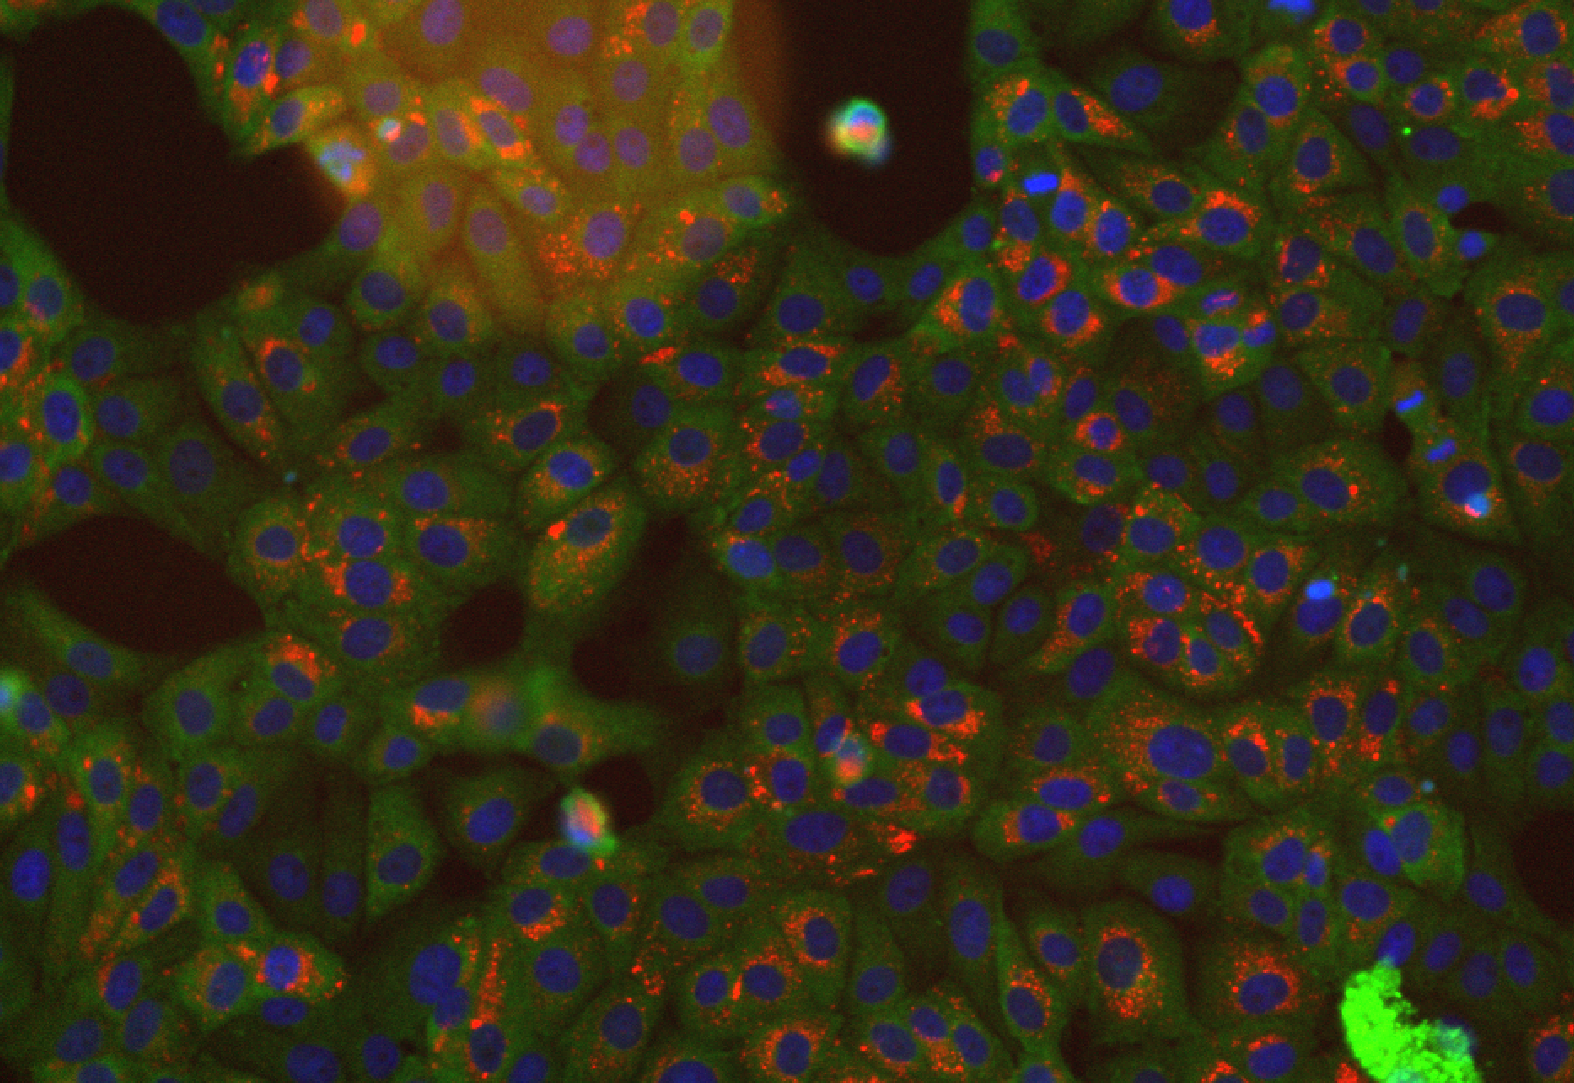

The green channel stains the cytosol and it's intensity encodes the strength of the antibody binding. The blue channel stains the nuclei, and the red channel stains viral RNA, i.e. indicating whether the virus is present or not in a cell.



On top of this we have the cell segmentation (shown here as outlines):
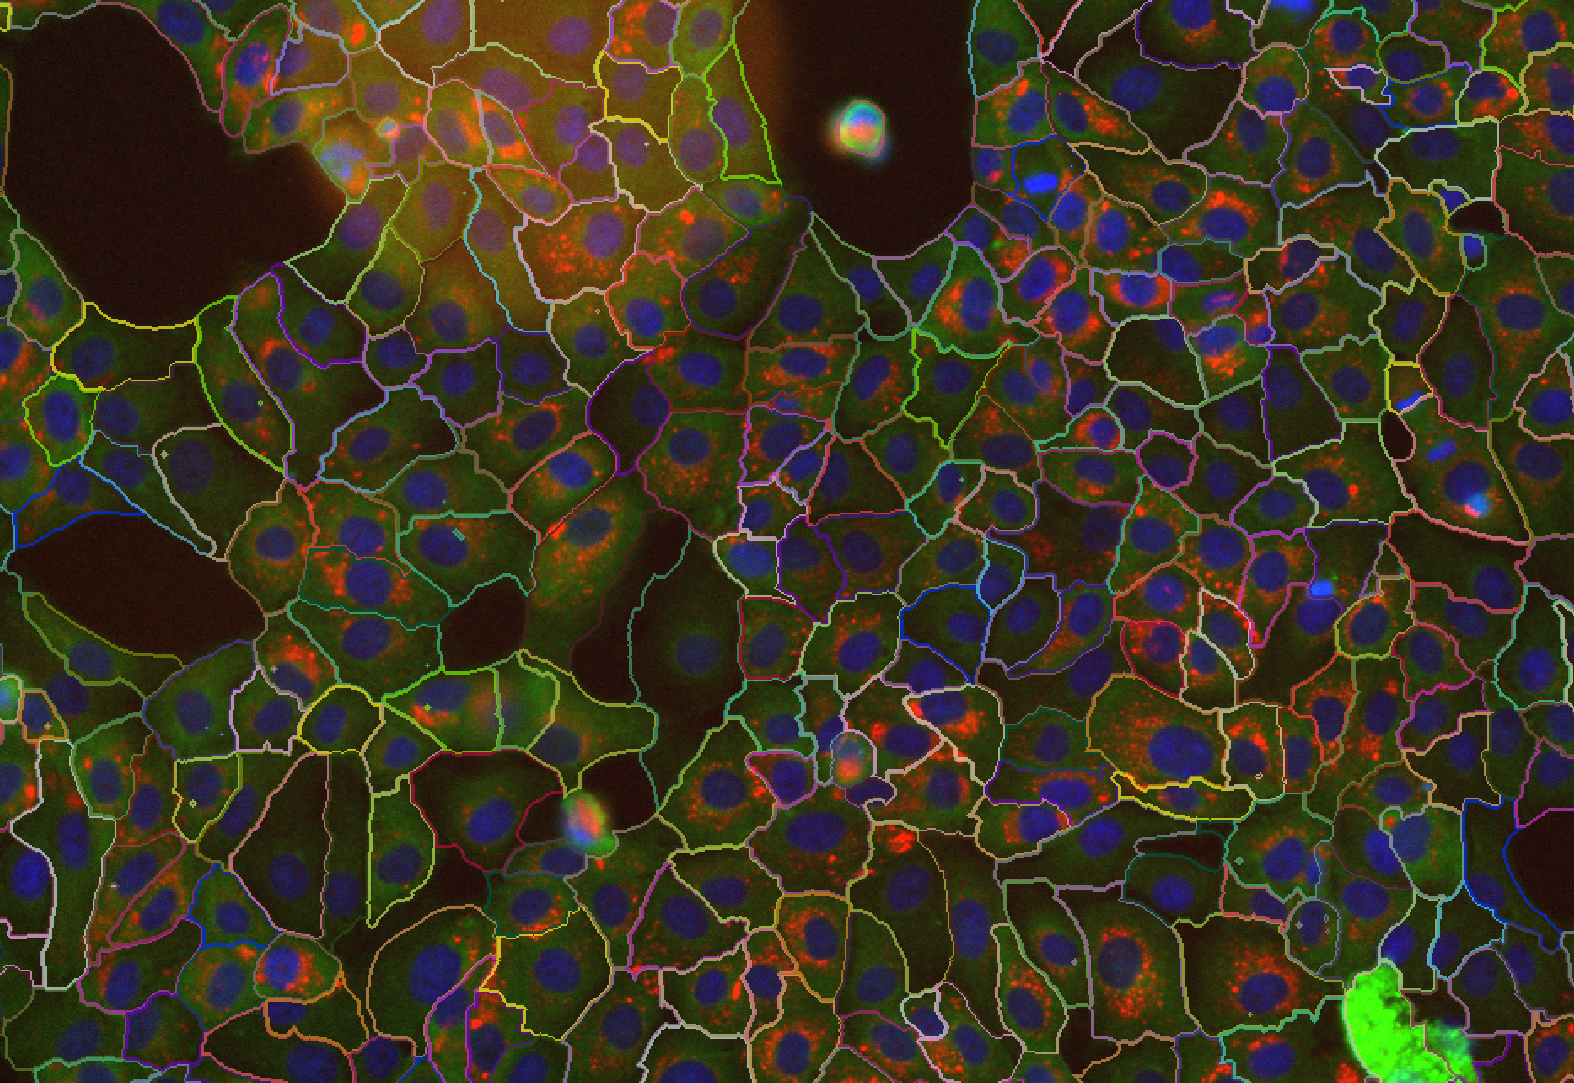


And the semantic segmentation of infected vs. non-infected cells
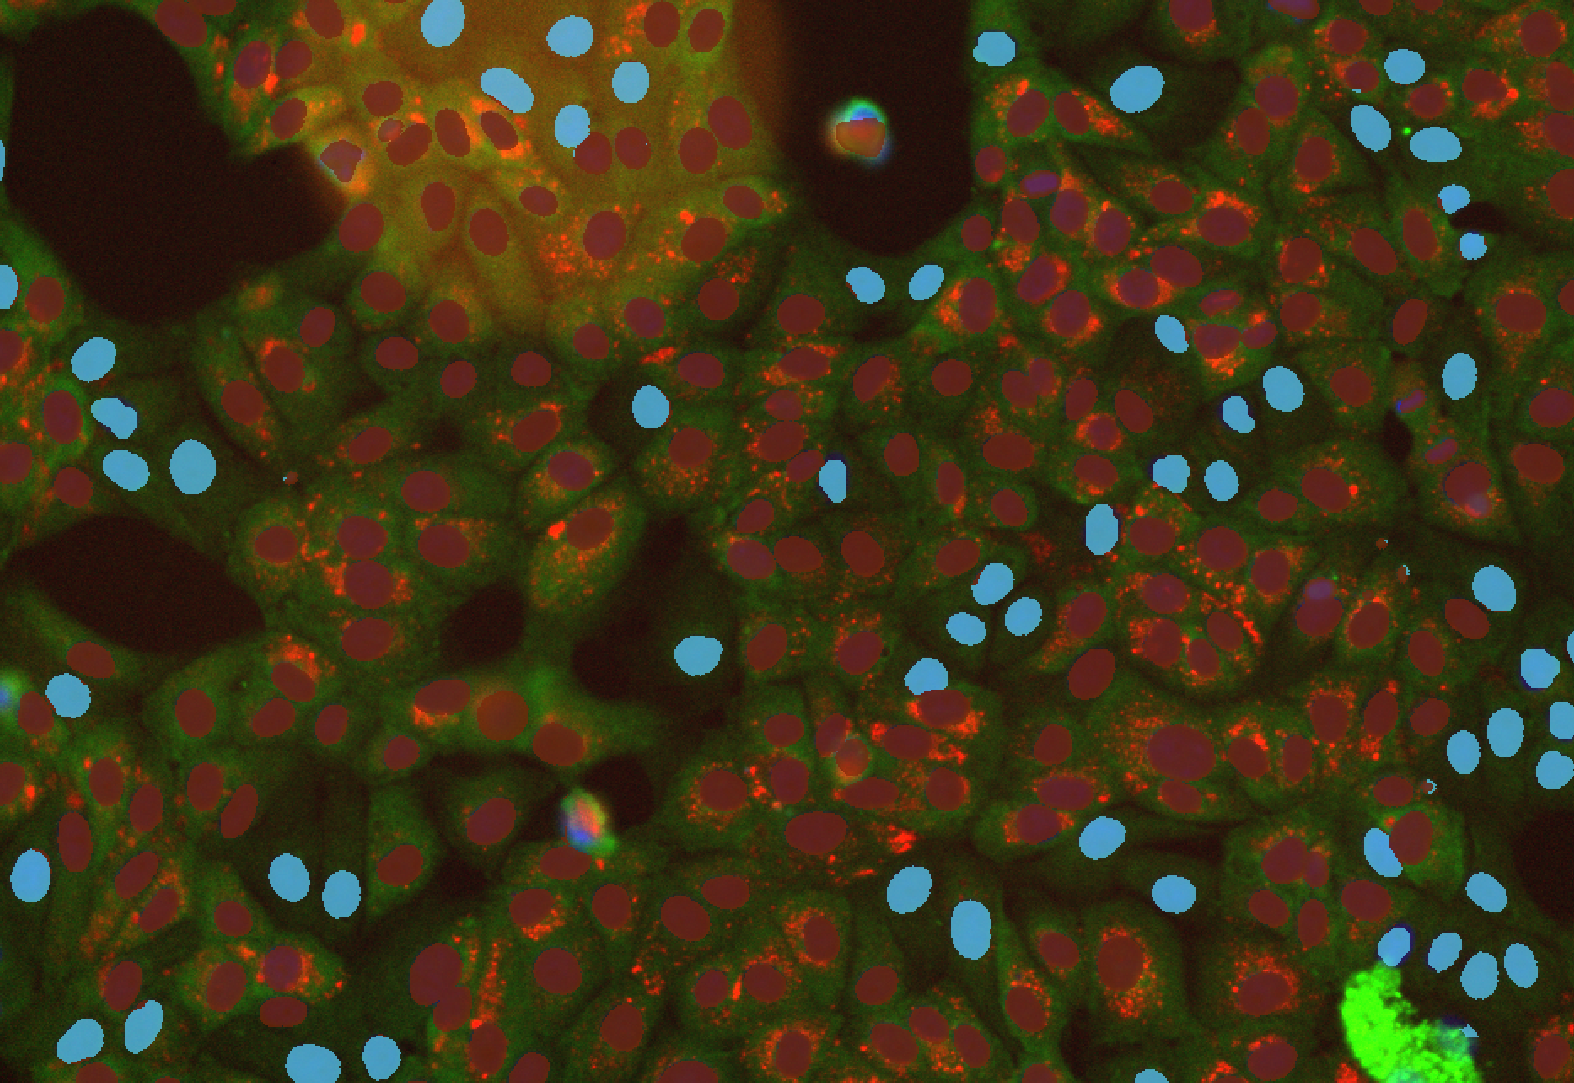

Here, the red nuclei (value: 1) mean that the corresponging cell is infected and blue nuclei (value: 2) mean it is not infected. You can clearly see that the infection is derived from the presence/absence of the viral marker (red image channel) in the cell.

### 4. Data splits

Finally, we split the data into a `training`, `validation` and `test` split. Having data splits is very important when training deep learning methods to objectively validate their performance. The role of these splits is:
- training: used to train the network via gradient descent. It is very important to not evaluate the performance of the network on this data because it will likely be better compared to data not used for training.
- validation: used to monitor the performance of the network during training and determine good hyperparameters (e.g. to tune parameters for post-processing)
- test: used to evaluate the performance of the network. It is important to not neither use this split for training the network nor optimiizing hyperparameters.

We have 49 images and split them into 35 images for training, 5 for validation and the rest for testing. Note: when creating these splits it's important to make sure that all three splits reflect the full characteristics of the data. Here, it's sufficient to just split the images according to their numbering (which does not have any real meaning).

In [ ]:
# get all image file paths using glob, which allows to select files with '*' wildcards
# e.g. glob('*.h5') will select all files that have the .h5 file ending
from glob import glob

file_paths = glob(os.path.join(data_folder, "*.h5"))
file_paths.sort()
print("You have selected", len(file_paths), "files")

In [ ]:
# create the train, validation (val) and test splits by creating sub-folders for each split
# and copying the respective files there
from shutil import copyfile

n_train = 35
train_folder = os.path.join(data_folder, "train")
os.makedirs(train_folder, exist_ok=True)
for train_image in file_paths[:n_train]:
    copyfile(train_image, os.path.join(train_folder, os.path.basename(train_image)))

n_val = 5
val_folder = os.path.join(data_folder, "val")
os.makedirs(val_folder, exist_ok=True)
for val_image in file_paths[n_train:n_train+n_val]:
    copyfile(val_image, os.path.join(val_folder, os.path.basename(val_image)))
    
test_folder = os.path.join(data_folder, "test")
os.makedirs(test_folder, exist_ok=True)
for test_image in file_paths[n_train+n_val:]:
    copyfile(test_image, os.path.join(test_folder, os.path.basename(test_image)))

In [ ]:
# double check that we have the correct number of images in the split folders
print("We have", len(glob(os.path.join(train_folder, "*.h5"))), "training images")
print("We have", len(glob(os.path.join(val_folder, "*.h5"))), "validation images")
print("We have", len(glob(os.path.join(test_folder, "*.h5"))), "test images")

**Now that you understand the data and have created the splits we can start with the first task: nucleus segmentation!**